# Clever filtering using pytorch optimizers and layers

I didn't have good luck using my own gradient descent so I'm using this as an opportunity to learn the higher level pytorch mechanisms like `torch.nn`. This [tutorial on pytorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) is very good.

## Support code

In [3]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [5]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1  NB: Different than I usually do (1..n)!!!!
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [6]:
def top_movies(df, n=100):
    rating_count = df.groupby('movieId')['rating'].count()
    top_movieIds = rating_count.sort_values(ascending=False).index.values[:n]

    df_top = df[df['movieId'].isin(top_movieIds)][['movieId','title','genres']].drop_duplicates()
    return df_top

In [18]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [120]:
from sklearn.decomposition import PCA

def mcolor(genre):
    if 'Comedy' in genre: return 'green'
    if 'Sci-Fi' in genre: return 'cyan'
    if 'War' in genre: return 'red'
    if 'Drama' in genre: return '#FEE08F'
    return 'black'

def plot_comedy_drama_embeddings(df, movie_embeddings, n=1000, xrange=(-1,1), yrange=(-1,1)):
#    df_movies = df[(df['genres'].str.contains('Comedy'))|(df['genres'].str.contains('Drama'))]
#     df_movies = top_movies(df_movies, n)
    df_movies = top_movies(df, n)
    movie_embeddings = movie_embeddings[df_movies['movieId'].values]
    
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [mcolor(genres[i]) for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5, alpha=.5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()
    return df_movies, vecs2D

In [123]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

output_notebook() # send to notebook not tab

def plot_bokeh_comend_drama_embeddings(df_movies, vecs2D):
    data = dict(
        x=vecs2D[:,0],
        y=vecs2D[:,1],
        title = df_movies['title'],
        genre = df_movies['genres'],
        colors = [mcolor(df_movies['genres'].iloc[i]) for i in range(len(vecs2D))]
    )
    source = ColumnDataSource(data)
    fig = figure(plot_width=500, plot_height=300,
                 title='Movie embeddings projected with PCA',
                 tools='pan,wheel_zoom,zoom_in,box_zoom,reset,hover',
                 x_axis_type=None, y_axis_type=None, min_border=1)
    fig.scatter(x='x', y='y',source=source, fill_alpha=0.7, size=5, fill_color='colors')
    # hover tools,
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips = {'content': '@title'}
    show(fig)

Loading BokehJS ...

## Load and train

In [41]:
df = load(n=10_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,255,1236,4.0,"Thomas Crown Affair, The",Action|Mystery
1,365,1236,4.0,"Thomas Crown Affair, The",Action|Mystery


In [42]:
avg_rating = np.mean(df['rating'])
avg_rating

3.4853

In [ ]:
nfactors = 16
n_train = int(n*0.90)
n_valid = n - n_train

# U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True, std=0.01, mean=math.sqrt(avg_rating/nfactors))
# M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True, std=0.01, mean=math.sqrt(avg_rating/nfactors))
U      = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
               std=0.01, mean=math.sqrt(avg_rating/nfactors))
U_bias = randn(nusers,  1,        device=device, dtype=dtype, requires_grad=True,
               std=0.01, mean=avg_rating/nfactors)
M      = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
               std=0.01, mean=math.sqrt(avg_rating/nfactors))
M_bias = randn(nmovies, 1,        device=device, dtype=dtype, requires_grad=True,
               std=0.01, mean=avg_rating/nfactors)

data = torch.tensor( df[['userId','movieId','rating']].values )


def mse_loss(U, M, U_bias, M_bias, data):
    # data has (user, movie, rating) records
    r_pred = (U[data[:,0].long()] * M[data[:,1].long()]).sum(axis=1, keepdim=True)
    r_pred += (U_bias[data[:,0].long()] + M_bias[data[:,1].long()])
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(data[:,2])
    return torch.mean( diff.pow(2) )

def mae_loss(U, M, U_bias, M_bias, data):
    r_pred = (U[data[:,0].long()] * M[data[:,1].long()]).sum(axis=1, keepdim=True)
    r_pred += (U_bias[data[:,0].long()] + M_bias[data[:,1].long()])
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(data[:,2])
    return torch.mean( diff.abs() )

indices = torch.randperm(n)
train_idx = indices[0:n_train]
valid_idx = indices[n_train:]
train, valid = data[train_idx], data[valid_idx] # copying data but could not get columns out of a Subset object
# train, valid = data, data
print(f"{len(train)} training and {len(valid)} validation records")

batch_size = 256
weight_decay = 0.0#0001
learning_rate = 1e-2
optimizer = torch.optim.Adam([U,M,U_bias,M_bias], lr=learning_rate)

history = []

# Start history with what random weights show
with torch.no_grad():
    loss = mse_loss(U, M, U_bias, M_bias, train)
    l2_weight_penalty = weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
    loss += l2_weight_penalty
    valid_loss = mse_loss(U, M, U_bias, M_bias, valid)
    valid_loss += l2_weight_penalty
history.append( (loss, valid_loss) )
print(f"Init      MSE training {loss:4.3f} valid {valid_loss:4.3f}")

hU = torch.zeros(size=(nusers, nfactors),  device=device, dtype=dtype)
hM = torch.zeros(size=(nmovies, nfactors), device=device, dtype=dtype)

for t in range(300): # epochs
    permutation = torch.randperm(train.size()[0])
    
    for k in range(0, train.size()[0], batch_size): # mini-batch
        batch_indices = permutation[k:k+batch_size]
        batch_x, batch_y = train[batch_indices], train[batch_indices]

        loss = mse_loss(U, M, U_bias, M_bias, batch_x)
#         l2_weight_penalty = weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
#         loss += l2_weight_penalty

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()

    with torch.no_grad():
        loss = mse_loss(U, M, U_bias, M_bias, train)
#         l2_weight_penalty = weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
#         loss += l2_weight_penalty
        valid_loss = mse_loss(U, M, U_bias, M_bias, valid)
#         valid_loss += l2_weight_penalty
    history.append( (loss, valid_loss) )
    if t % 20 == 0:
        print(f"Epoch {t:3d} MSE {loss:4.3f}, valid {valid_loss:4.3f}   MAE {mae_loss(U, M, U_bias, M_bias, train).detach().item():4.3f}, {mae_loss(U, M, U_bias, M_bias, valid).detach().item():4.3f}")

history = torch.tensor(history)

# m1 = mae_loss(U, M, train).detach().item()
# m2 = mae_loss(U, M, valid).detach().item()
# print("MAE training", m1, "validation", m2)

plot_history(history, yrange=(0,3), figsize=(3.5,1.5))

9000 training and 1000 validation records


/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Init      MSE training 3.102 valid 3.045


/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch   0 MSE 1.354, valid 1.323   MAE 0.907, 0.891
Epoch  20 MSE 1.109, valid 1.052   MAE 0.839, 0.801


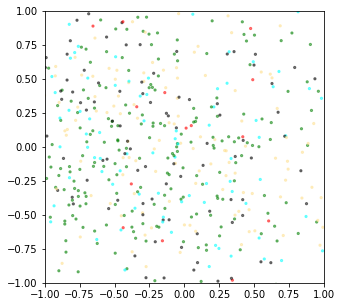

In [129]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), n=1000)#, xrange=(-3,3), yrange=(-3,3))

In [130]:
plot_bokeh_comend_drama_embeddings(df_movies, vecs2D)